In [1]:
import sys; sys.path.append('../rrr')
import decoy_mnist
from multilayer_perceptron import *
from figure_grid import *
from local_linear_explanation import *
import random
import numpy as np
import matplotlib.pyplot as plt

# Decoy MNIST

This is a version of MNIST augmented with color splotches that correspond to the digits in the training set but not the test set. These color splotches are a "decoy rule" the model could inappropriately learn and try to apply to the test set, similar to the Husky vs. Wolf problem in [LIME](https://arxiv.org/abs/1602.04938).

Let's see if we can fool the perceptron but then help it correct its mistake.

In [2]:
Xr, X, y, E, Xtr, Xt, yt, Et = decoy_mnist.generate_dataset(cachefile='../data/decoy-mnist.npz')
Xr = np.array([x.ravel() for x in Xr])
Xtr = np.array([x.ravel() for x in Xtr])

Let's visualize our dataset first:

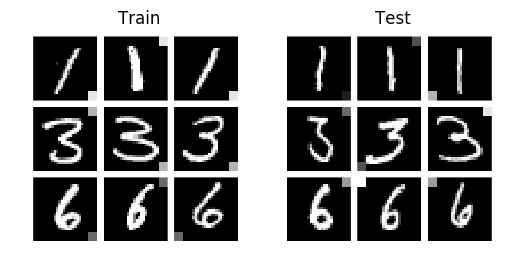

In [3]:
def examples_matching(digits, X, y):
  return X[np.array([list(np.argwhere(y==d).T[0][167:230]) for d in digits]).T.ravel()]

plt.subplot(121)
plt.title('Train')
image_grid(examples_matching([1,3,6], X, y), (28,28), 3)
plt.subplot(122)
plt.title('Test')
image_grid(examples_matching([1,3,6], Xt, yt), (28,28), 3)
plt.show()

Note that all training examples have the same splotch color for each digit, and all test examples have randomly colored splotches. We'll train three models: an MLP on the decoy set normally, an MLP on the decoy set with annotations to help it generalize, and an MLP on the actual MNIST dataset.

In [4]:
mlp_normal = MultilayerPerceptron()
mlp_normal.fit(X, y)
print(mlp_normal.score(X, y))
print(mlp_normal.score(Xt, yt))

0.995816666667
0.552


In [5]:
mlp_annotated = MultilayerPerceptron(l2_grads=1000)
mlp_annotated.fit(X, y, E)
print(mlp_annotated.score(X, y))
print(mlp_annotated.score(Xt, yt))

0.9847
0.9604


In [6]:
mlp_nondecoy = MultilayerPerceptron()
mlp_nondecoy.fit(Xr, y)
print(mlp_nondecoy.score(Xtr, yt))
print(mlp_nondecoy.score(Xr, y))

0.9578
0.9847


In [7]:
test_scores = [mlp_normal.score(Xt, yt), mlp_annotated.score(Xt, yt), mlp_nondecoy.score(Xtr, yt)]
model_names = ['$A=0$', 'full $A$', 'Baseline']

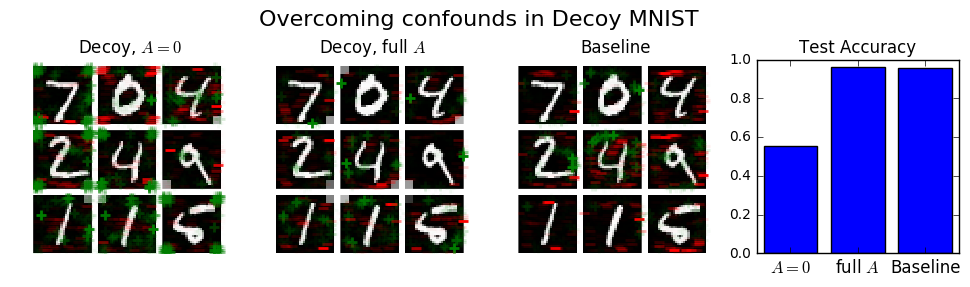

In [412]:
def explain(model, title='', length=3, i=0, Xt=Xt, **kwargs):
  plt.title(title)
  explanation_grid(model.grad_explain(Xt[i:i+length*length]), (28,28), length, **kwargs)
ii=0
ss=50
plt.figure(figsize=(12,2.5))
plt.suptitle('Overcoming confounds in Decoy MNIST', y=1.1, fontsize=16)
plt.subplot(141)
explain(mlp_normal, 'Decoy, $A=0$',i=ii,size=ss)
plt.subplot(142)
explain(mlp_annotated, 'Decoy, full $A$',i=ii,size=ss)
plt.subplot(143)
explain(mlp_nondecoy, 'Baseline', Xt=Xtr,i=ii,size=ss)
plt.subplot(144)
plt.title('Test Accuracy')
plt.bar(np.arange(len(test_scores))+0.1, test_scores)
plt.gca().set_xticks([0.5,1.5,2.5])
plt.gca().set_xticklabels(model_names, fontsize=12)
plt.xlim(0,3)
plt.ylim(0,1)

plt.show()

It looks like the decoy model focuses many of its input gradients on the corners, but the baseline model and the model trained to ignore the corners both achieve high test accuracy.

## Comparison with LIME

Let's see how the (newly-released) [image version of LIME](http://marcotcr.github.io/lime/tutorials/Tutorial%20-%20images.html) does compared to gradients. Let's consider the first example:

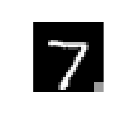

In [30]:
plt.figure(figsize=(1,1))
image_grid(Xt[:1], (28,28), 1)
plt.show()

This is an example our classifier gets confused about because of the decoy rule, as we can see from its assigned probabilities:

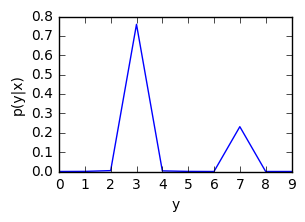

In [148]:
plt.figure(figsize=(3,2))
plt.plot(mlp_normal.predict_proba(Xt[:1])[0])
plt.xlabel('y')
plt.ylabel('p(y|x)')
plt.show()

Let's compare input gradients to LIME and see whether they agree. Note that to use LIME, as of this release, we're going to have to convert our BW image to RGB (which may change in future releases).

In [12]:
from lime import lime_image
lime_explainer = lime_image.LimeImageExplainer()

In [223]:
import time

def to_rgb(bw_image, l=28, w=28):
  result = np.zeros((l,w,3))
  for i in range(l):
    for j in range(w):
      value = bw_image.reshape((l,w))[i][j]
      for k in range(3):
        result[i][j] = 255-value
  return result

def to_bw(rgb_image, l=28, w=28):
  result = np.zeros((l,w))
  for i in range(l):
    for j in range(w):
      result[i][j] = 255-rgb_image.reshape((l,w,3))[i][j][0]
  return result.ravel()

def predict_fn_for(mlp):
  return lambda image: mlp.predict_proba(np.array([to_bw(image, 28, 28)]))

t1 = time.clock()
lime_explanation = lime_explainer.explain_instance(
  to_rgb(Xt[0], predict_fn_for(mlp_normal), top_labels=2, hide_color=True, num_samples=1000, batch_size=1)
t2 = time.clock()

print('LIME for took {:.5f}s'.format(t2-t1))

LIME for took 1.65217s


In [192]:
t3 = time.clock()
mlp_normal.input_gradients(Xt)
t4 = time.clock()
print('gradients took {:.6f}s/example'.format((t4-t3)/len(Xt)))

gradients took 0.000045s/example


In [131]:
grad_explanation3 = LocalLinearExplanation(Xt[0], 3, mlp_normal.input_gradients(Xt[:1], y=3))
grad_explanation7 = LocalLinearExplanation(Xt[0], 7, mlp_normal.input_gradients(Xt[:1], y=7))

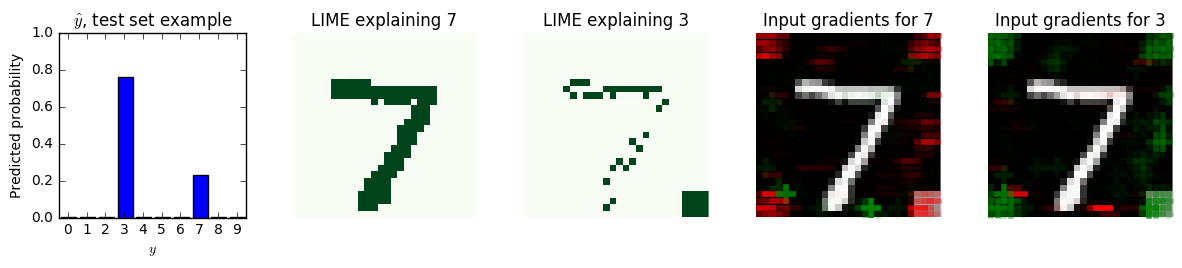

In [554]:
img7, mask7 = lime_explanation.get_image_and_mask(7)
img3, mask3 = lime_explanation.get_image_and_mask(3)

with figure_grid(1,5,rowheight=2.8) as g:
  g.next()
  plt.bar(np.arange(10)-0.35, mlp_normal.predict_proba(Xt[:1])[0])
  plt.xticks(range(10))
  plt.title(r'$\hat{y}$, test set example')
  plt.xlabel(r'$y$')
  plt.ylim(0,1)
  plt.ylabel('Predicted probability')
  plt.xlim(-0.5, 9.5)
  
  g.next()
  plt.title('LIME explaining 7')
  plt.axis('off')
  plt.imshow(255-mask7, interpolation='none', cmap='Greens')
  
  g.next()
  plt.title('LIME explaining 3')
  plt.axis('off')
  plt.imshow(255-mask3, interpolation='none', cmap='Greens')
  
  g.next()
  plt.title(r'Input gradients for 7')
  plt.xlim(0,28)
  plt.ylim(0,28)
  plt.axis('off')
  imshow_bw(grad_explanation7, (28,28), size=200, lw=4)
  
  g.next()
  plt.title(r'Input gradients for 3')
  plt.xlim(0,28)
  plt.ylim(0,28)
  plt.axis('off')
  imshow_bw(grad_explanation3, (28,28), size=200, lw=4)

LIME is only outputting masks, but we can see that for 7 it focuses on the digit, and for 3, it focuses on the decoy, which makes sense. Gradients focus on the decoy in both cases, because changing the decoy swatch in any location will have a strong effect on the outputted probability. Here we can see the major differences in the implicit counterfactuals behind LIME and gradient explanations: LIME adds or removes superpixels present in the image, so it focuses on areas in the image, while gradients can "imagine" adding elements to the image that aren't actually there. Both have strengths and weaknesses. The agreement on at least identifying the swatch shows that both methods are useful for this problem, however.

## Find-another-explanation

The training procedure is implemented in a separate script in `bin`, but let's analyze its results here:

In [298]:
import pickle
fae_1000s = [MultilayerPerceptron.from_params(p)
             for p in pickle.load(open('../data/decoy_mnist_fae_1000', 'rb'))]
fae_10000s = [MultilayerPerceptron.from_params(p)
             for p in pickle.load(open('../data/decoy_mnist_fae_10000', 'rb'))]
fae_100000s = [MultilayerPerceptron.from_params(p)
             for p in pickle.load(open('../data/decoy_mnist_fae_100000', 'rb'))]

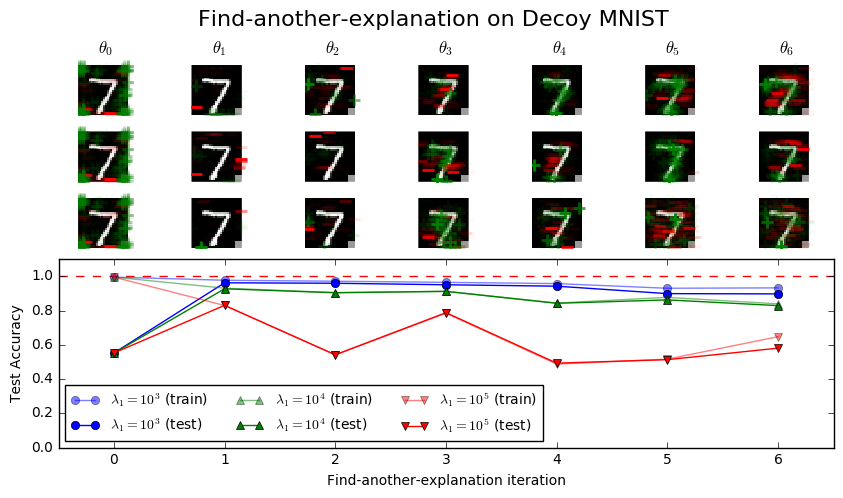

In [416]:
def accs(faes):
  return [fae.score(Xt,yt) for fae in faes]
def traccs(faes):
  return [fae.score(X,y) for fae in faes]

plt.figure(figsize=(10,5))
plt.suptitle('Find-another-explanation on Decoy MNIST', y=1.0, fontsize=16)
gridsize = (6,7)
example = 0

for i in range(7):
  plt.subplot2grid(gridsize, (0,i))
  explain(fae_1000s[i], r'$\theta_{}$'.format(i), 1, i=example)
  
for i in range(7):
  plt.subplot2grid(gridsize, (1,i))
  explain(fae_10000s[i], '', 1, i=example)
  
for i in range(7):
  plt.subplot2grid(gridsize, (2,i))
  explain(fae_100000s[i], '', 1, i=example)

plt.subplot2grid(gridsize, (3,0), rowspan=3, colspan=7)
plt.axhline(1, color='red', ls='--')
plt.plot(list(range(len(fae_1000s))), traccs(fae_1000s), marker='o', label=r'$\lambda_1=10^3$ (train)', alpha=0.5, c='blue')
plt.plot(list(range(len(fae_1000s))), accs(fae_1000s), marker='o', label=r'$\lambda_1=10^3$ (test)', c='blue')
plt.plot(list(range(len(fae_10000s))), traccs(fae_10000s), marker='^', label=r'$\lambda_1=10^4$ (train)', alpha=0.5, c='green')
plt.plot(list(range(len(fae_10000s))), accs(fae_10000s), marker='^', label=r'$\lambda_1=10^4$ (test)', c='green')
plt.plot(list(range(len(fae_100000s))), traccs(fae_100000s), marker='v', label=r'$\lambda_1=10^5$ (train)', c='red', alpha=0.5)
plt.plot(list(range(len(fae_100000s))), accs(fae_100000s), marker='v', label=r'$\lambda_1=10^5$ (test)', c='red')
plt.legend(loc='best', fontsize=10, ncol=3)
plt.xlim(-0.5, 6.5)
plt.ylim(0.0, 1.1)
plt.xlabel(r'Find-another-explanation iteration')
plt.ylabel('Test Accuracy')
  
plt.show()

We can see that test accuracy increases after the first iteration, then slowly trends downward, possibly because we are biasing the model against considering the most significant elements of each image. For high $\lambda_1$, this happens much more abruptly, and even after just one iteration accuracy isn't quite back to ideal, perhaps because the original model did still consider some important components.

## Investigating cutoffs

Let's also just interrogate our arbitrary choice of cutoff slightly:

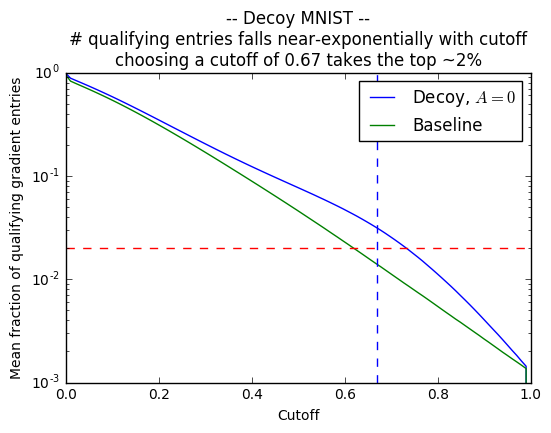

In [29]:
def M(input_gradients, cutoff=0.67):
  return np.array([np.abs(e) > cutoff*np.abs(e).max() for e in input_gradients]).astype(int).ravel()

grads = mlp_normal.input_gradients(Xt)

cutoffs = np.linspace(0,1,100)
cutoff_pcts = np.array([M(grads, c).sum() / float(len(grads.ravel())) for c in cutoffs])

grads2 = mlp_nondecoy.input_gradients(Xtr)
cutoff_pcts2 = np.array([M(grads2, c).sum() / float(len(grads2.ravel())) for c in cutoffs])

plt.plot(cutoffs, cutoff_pcts, label='Decoy, $A=0$')
plt.plot(cutoffs, cutoff_pcts2, label='Baseline')
plt.legend(loc='best')
plt.xlabel('Cutoff')
plt.ylabel('Mean fraction of qualifying gradient entries')
plt.yticks(np.linspace(0,1,21))
plt.axhline(0.02, ls='--', c='red')
plt.axvline(0.67, ls='--', c='blue')
plt.yscale('log')
plt.title('-- Decoy MNIST --\n# qualifying entries falls near-exponentially with cutoff\nchoosing a cutoff of 0.67 takes the top ~2%')
plt.show()

Here there does appear to be a bit of a kink in the curve at least for the decoy model, and it's about at where we chose our cutoff.